In [1]:
import numpy as np
from skimage.draw import disk
mask = np.zeros((10, 10), dtype=np.uint8)
row = 4
col = 5
radius = 5
# modern scikit uses a tuple for center
rr, cc = disk((row, col), radius)
mask[rr, cc] = 1

In [2]:
from matplotlib import pyplot as plt

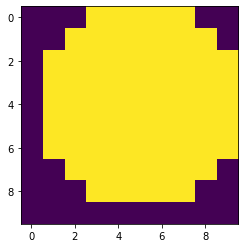

In [3]:
plt.imshow(mask)

In [4]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [5]:
h=10
w=10
im = np.zeros((8, 8), dtype=np.uint8)

In [7]:
row = 4
col = 5
radius = 5
mask2 = create_circular_mask(h,w,center=(row,col),radius=radius)

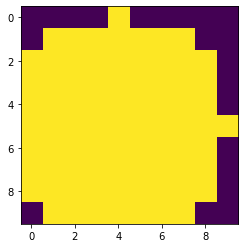

In [8]:
plt.imshow(mask2)

# Removing objects within a elliptical area

https://facultyweb.siena.edu/~rfinn/virgo/cutouts/VFID0610-NGC5985-INT-20190530-p040/VFID0610-NGC5985-INT-20190530-p040.html

https://facultyweb.siena.edu/~rfinn/virgo/cutouts/VFID0775-UGC09837-BOK-20220425-VFID0776/VFID0775-UGC09837-BOK-20220425-VFID0776.html

In [1]:
import os
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
homedir = os.getenv("HOME")

In [2]:
os.chdir(homedir+'/research/Virgo/maskwrapper-test/VFID0775-UGC09837-BOK-20220425-VFID0776')

In [6]:
!cp VFID0775-UGC09837-BOK-20220425-VFID0776-R-mask.fits test-mask.fits


In [8]:
mhdu = fits.open('test-mask.fits')

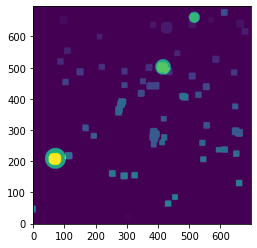

In [9]:
plt.figure()
plt.imshow(mhdu[0].data,origin='lower')

In [36]:
sma = 150
BA = .5
a = sma
b = BA*a
xc = 350
yc = 350
phi = 10
phirad = np.radians(phi)

In [23]:
xmax,ymax = mhdu[0].data.shape

In [22]:
np.meshgrid(10,10)

[array([[10]]), array([[10]])]

In [24]:
X,Y = np.meshgrid(np.arange(xmax),np.arange(ymax))

In [25]:
X

array([[  0,   1,   2, ..., 694, 695, 696],
       [  0,   1,   2, ..., 694, 695, 696],
       [  0,   1,   2, ..., 694, 695, 696],
       ...,
       [  0,   1,   2, ..., 694, 695, 696],
       [  0,   1,   2, ..., 694, 695, 696],
       [  0,   1,   2, ..., 694, 695, 696]])

In [39]:
flag = ((X*np.cos(phirad)-xc)/(a))**2 + ((Y*np.sin(phirad)-yc)/(b))**2 < 1

In [43]:
p1 = ((X-xc)*np.cos(phirad)+(Y-yc)*np.sin(phirad))**2/a**2
p2 = ((X-xc)*np.sin(phirad)-(Y-yc)*np.cos(phirad))**2/b**2
flag2 = p1+p2 < 1

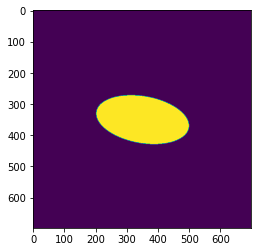

In [44]:
plt.imshow(flag2)

In [45]:
def remove_central_objects(mask, sma, PA, BA, xc=None,yc=None):
    """ find any pixels within central ellipse and set their values to zero """
    xmax,ymax = mask.shape
    # set center of ellipse as the center of the image
    if (xc is None) and (yc is None):
        xc,yc = xmax//2,ymax//2
    a = sma
    b = BA*sma
    phirad = np.radians(PA)
    p1 = ((X-xc)*np.cos(phirad)+(Y-yc)*np.sin(phirad))**2/a**2
    p2 = ((X-xc)*np.sin(phirad)-(Y-yc)*np.cos(phirad))**2/b**2
    flag2 = p1+p2 < 1
    newmask = np.copy(mask)
    newmask[flag2] = 0
    return newmask


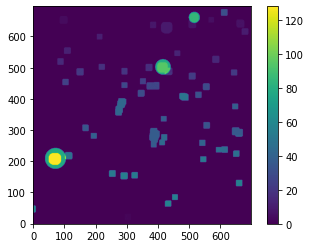

In [50]:
plt.figure()
plt.imshow(mhdu[0].data,origin='lower')
plt.colorbar()

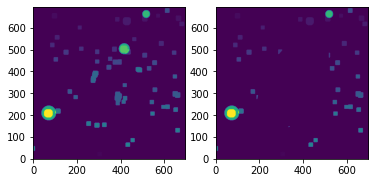

In [51]:
PA = 30
sma = 250
BA = .5
a = sma
b = BA*a
xc = 350
yc = 350

newmask = remove_central_objects(mhdu[0].data,sma,90-PA,BA)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mhdu[0].data,origin='lower')
plt.subplot(1,2,2)
plt.imshow(newmask,origin='lower')

# Testing on one galaxy

In [3]:
os.chdir(homedir+'/research/Virgo/maskwrapper-test/VFID0775-UGC09837-BOK-20220425-VFID0776')

In [7]:
# import programs
import os
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
homedir = os.getenv("HOME")


In [18]:
import sys
sys.path.append(homedir+'/github/halphagui/')
from maskwrapper import maskwindow

ValueError: PyCapsule_GetPointer called with incorrect name

In [5]:
# read in virgo files and get igal
%run ~/github/Virgo/programs/readtablesv2.py

In [8]:
# set up image names
rcutout = 'VFID0775-UGC09837-BOK-20220425-VFID0776-R.fits'

wcs = WCS(fits.getheader(rcutout))      

In [15]:
# get galaxy
igal = v.main['VFID'] == 'VFID0775'
igal = np.arange(len(v.main))[igal][0]
print(igal)
v.main['RA'][igal]

775


230.965329

In [29]:
# set up objparams
ra = v.main['RA'][igal]
dec = v.main['DEC'][igal]
sma = v.ephot['SMA_SB24'][igal]
BA = v.ephot['BA_MOMENT'][igal]
PA = v.ephot['PA_MOMENT'][igal]

#convert 
# get x and y coord of galaxy from (RA,DEC) using mask wcs
xpixel,ypixel = wcs.wcs_world2pix(ra,dec,0)
            
# convert sma to pixels using pixel scale from mask wcs
pixel_scale = wcs.pixel_scale_matrix[1][1]
objsma_pixels = sma/(pixel_scale*3600)
objparams = [ra,dec,sma/pixel_scale,BA,PA]
print(f"--objra {ra} --objdec {dec} --objsma {1.3*sma:.1f} --objBA {BA:.2f} --objPA {PA:.2f}")

--objra 230.965329 --objdec 58.0529766 --objsma 54.9 --objBA 0.89 --objPA 128.82


In [17]:

mui = maskwindow(None, None, image = rcutout, haimage=None,\
                 sepath='~/github/halphagui/astromatic/',auto=True,\
                 objparams=objparams,unmaskellipse=True)
                           

NameError: name 'maskwindow' is not defined

# Testing masking code again for WISEsize



In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

In [5]:
os.chdir('/home/rfinn/research/Virgo-dev/wisesize-masks/')

In [6]:
%run ~/github/halphagui/mask1galaxy.py VFID0821

trying to find virgo catalogs
/home/rfinn/research/Virgo-dev/wisesize-masks/VFID0821/
remaking mask
python /home/rfinn/github/halphagui/maskwrapper.py --image NGC3669-custom-image-r.fits --objra 171.36157500000002 --objdec 57.7212495 --objsma 107.4 --objBA 0.3 --objPA 153.5 --sepath /home/rfinn/github/halphagui/astromatic/ --auto

done masking VFID0821



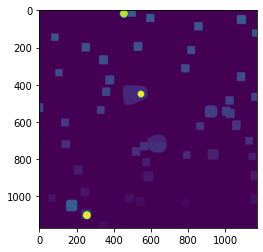

In [11]:
maskfile = 'NGC3669-custom-image-r-mask.fits'
data = fits.getdata(maskfile)
plt.imshow(data)
# draw ellipse

In [25]:
%run /home/rfinn/github/halphagui/maskwrapper.py --image NGC3669-custom-image-r.fits --objra 171.36157500000002 --objdec 57.7212495 --objsma 107.4 --objBA 0.3 --objPA 243.5 --sepath /home/rfinn/github/halphagui/astromatic/ --auto

testing - unmaskellipse =  True
NGC3669-custom-image-r.fits
None
/home/rfinn/github/halphagui/astromatic/
(1169, 1169) (1169, 1169)
using a deblending threshold =  0.005
sex NGC3669-custom-image-r.fits -c default.sex.HDI.mask -CATALOG_NAME NGC3669-custom-image-r.cat -CATALOG_TYPE FITS_1.0 -DEBLEND_MINCONT 0.005 -DETECT_THRESH 10 -ANALYSIS_THRESH 10 -CHECKIMAGE_NAME NGC3669-custom-image-r-segmentation.fits -DETECT_MINAREA 5
ellipse params in remove_central_object : 581.80889086613 582.5823935900368 409.9236641221373 0.3 243.5
['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'radius', 'xpixel', 'ypixel']
['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'radius', 'xpixel', 'ypixel']
mask value =  152.0
star 0: 546.2,450.0,18.2
star 1: 455.1,18.7,21.5
star 2: 256.4,1099.4,21.4
HELLO!!!

time to run se: 0.396 sec



BA=0.3,PA=243.50000000000003 deg


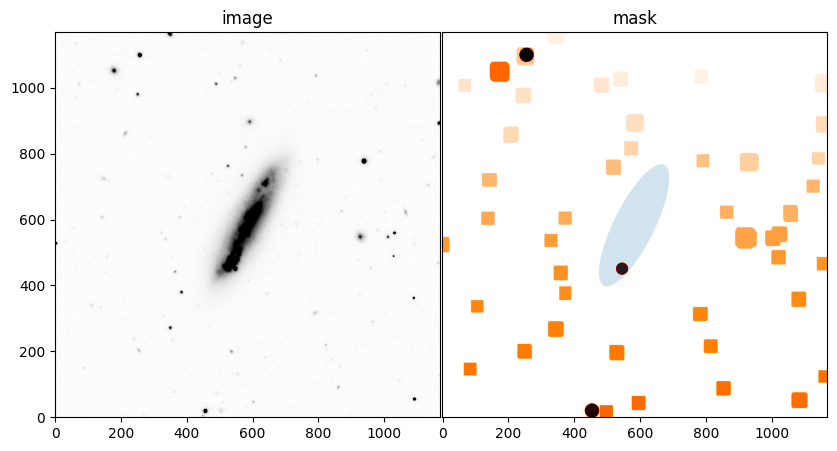

In [26]:
ui.show_mask_mpl()